In [1]:
import tensorflow as tf
tf.debugging.set_log_device_placement(True)

In [2]:
! nvidia-smi

Tue Jan 21 16:48:44 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.87.00    Driver Version: 418.87.00    CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-DGXS...  On   | 00000000:07:00.0 Off |                    0 |
| N/A   43C    P0    55W / 300W |  15477MiB / 16128MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-DGXS...  On   | 00000000:08:00.0 Off |                    0 |
| N/A   43C    P0    52W / 300W |    626MiB / 16128MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

# Misc on GPU usage

In [3]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  4


In [4]:
a = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
b = tf.constant([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])
c = tf.matmul(a, b)
print(c)

Executing op MatMul in device /job:localhost/replica:0/task:0/device:GPU:0
tf.Tensor(
[[22. 28.]
 [49. 64.]], shape=(2, 2), dtype=float32)


In [5]:
gpus = tf.config.experimental.list_physical_devices('GPU')

In [6]:
gpus[1].name

'/physical_device:GPU:1'

The following chunk intending to specify GPU device failed .. See reference at [link](https://www.tensorflow.org/guide/gpu#using_a_single_gpu_on_a_multi-gpu_system) but got no success yet.

In [7]:
# tf.config.set_soft_device_placement(True)
# tf.debugging.set_log_device_placement(True)
with tf.device('/job:localhost/replica:0/task:0/device:GPU:1'):
    a = tf.constant([[1,2]])
    b = tf.constant([[1,2],[3,4]])
    c = tf.matmul(a, b)

Executing op MatMul in device /job:localhost/replica:0/task:0/device:CPU:0


# The elastic net try starts here

Before getting started, for an record, here is the elastic net objective.

$$\beta_{en} = \arg\min_\beta \frac{1}{N}\|Y - X\beta\|_2^2 + \lambda (\alpha \|\beta\|_1 + (1 - \alpha) \|\beta\|_2^2)$$

As an exploratory effort, I'll try to implement using `keras` and `tf` built-in's.

## Simulate data

Here we aim for about 5k predictors and 30k observations. 
It would be ten fold smaller than the scale for PTRS training (to make the procedure a little easier). 
And we simulate a somewhat sparse model. 

In [8]:
update_data = False

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import h5py

In [10]:
def sample_spike_and_slab(shape, pi, mean, sd):
    bernoulli_part = np.random.binomial(1, pi, size = shape)
    norm_part = np.random.normal(loc = mean, scale = sd, size = shape)
    return bernoulli_part * norm_part
def norm_by_col(mat):
    # normalize such that col norm2 is 1
    norm2 = np.sqrt(np.power(mat, 2).sum(axis = 0))
    norm2[norm2 == 0] = 1
    return mat / norm2[np.newaxis, :]

In [11]:
num_predictors = int(5 * 1e3)
num_samples = int(30 * 1e3)
frac_causal = 0.05
num_causals = int(frac_causal * num_predictors)
intercept = 10
K = 50  # the number of independent predictors. And
# the observed predictors will be linear combination of these
ntrain = int(num_samples * 0.9)
ntest = int(num_samples * 0.1)

In [12]:
beta = np.zeros([num_predictors, 1])
beta[np.random.randint(0, num_predictors - 1, size = num_causals), 0] = 12 * (np.random.rand(num_causals) - 0.5)

Text(0, 0.5, 'beta')

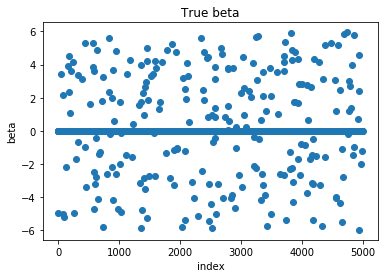

In [13]:
plt.scatter(range(num_predictors), beta)
plt.title('True beta')
plt.xlabel('index')
plt.ylabel('beta')

In [14]:
K_predictors = np.random.normal(loc = 0, scale = 1, size = [num_samples, K])
loadings = sample_spike_and_slab([K, num_predictors], pi = 0.05, mean = 0, sd = 1)
loadings = norm_by_col(loadings)
X = np.matmul(K_predictors, loadings)

In [15]:
noise = np.random.normal(loc = 0, scale = 10, size = (num_samples, 1))
genetic_part = np.matmul(X, beta)

In [16]:
y = genetic_part + intercept + noise

In [17]:
# split to training and test
train_idx = np.random.choice(num_samples, size = ntrain, replace = False)
test_idx = np.where(np.logical_not(np.isin(np.arange(num_samples), train_idx)))[0]
Xtrain = X[train_idx, ]
ytrain = y[train_idx, ]
Xtest = X[test_idx, ]
ytest = y[test_idx, ]
noisetest = noise[test_idx, ]
genetic_part_test = genetic_part[test_idx, ]

In [18]:
if update_data is True:
    # save data as hdf5 
    fx = h5py.File("/vol/bmd/yanyul/test_data/tf_elastic_net/example_X.hdf5", "w")
    fx.create_dataset("Xtrain", data = Xtrain)
    fx.create_dataset("ytrain", data = ytrain)
    fx.create_dataset("Xtest", data = Xtest)
    fx.create_dataset("ytest", data = ytest)
    fx.create_dataset('true_beta', data = beta)
    fx.create_dataset('intercept', data = intercept)
    fx.create_dataset('noisetest', data = noisetest)
    fx.create_dataset('genetic_part_test', data = genetic_part_test)
    fx.close()

## Implementation with TF built-in's

In [4]:
import tensorflow_io as tfio
import tensorflow as tf

In [20]:
def lambda_alpha_to_l1_l2(alpha, llambda):
    l1 = alpha * llambda
    l2 = (1 - alpha) * llambda
    return (l1, l2)

In [21]:
alpha = 0.5
llambda = 1

In [72]:
def lambda_alpha_to_l1_l2(alpha, llambda):
    l1 = alpha * llambda
    l2 = (1 - alpha) * llambda
    return (l1, l2)

class ElasticNet:
    def __init__(self, num_predictors, alpha, llambda, A = None, b = None):
        init = tf.random_normal_initializer()
        if A is None:
            A = tf.Variable(init(shape = [num_predictors, 1]), name = 'A')
        if b is None:
            b = tf.Variable(init(shape = [1, 1]), name = 'b')
        self.A = A
        self.b = b
        self.trainable_variables = [self.A, self.b]
        self.proximal_variables = [self.A]
        self.not_prox_variables = [self.b]
        l1, l2 = lambda_alpha_to_l1_l2(alpha, llambda)
        self.l1 = tf.constant(tf.cast(l1, tf.float32))
        self.l2 = tf.constant(tf.cast(l2, tf.float32))
        self.alpha = alpha
        self.lambda_ = llambda
#     @tf.function
    def forward(self, x):
#         print(x.shape)
#         print(self.A.shape)
        return tf.tensordot(x, self.A, axes = [1, 0]) + self.b
#     @tf.function
    def regu_l1(self):
        regu_l1 = tf.reduce_sum(tf.abs(self.A))
        return tf.multiply(self.l1, regu_l1)
    def regu_l2(self):
        regu_l2 = tf.reduce_sum(tf.square(self.A))
        return tf.multiply(self.l2, regu_l2)
    def regularization(self):
        return tf.add(self.regu_l1(), self.regu_l2()) 
#     @tf.function
    def loss(self, x, y):
        return tf.reduce_mean(tf.square(y - self.forward(x)))
#     @tf.function
    def objective(self, x, y):
        tmp = self.loss(x, y)
        return tf.add(tmp, self.regularization()), tmp
    def proximal_obj(self, x, y):
        tmp = self.loss(x, y)
        return tf.add(tmp, self.regu_l2()), tmp
    def update_lambda(self, llambda):
        l1, l2 = lambda_alpha_to_l1_l2(alpha, llambda)
        self.lambda_ = llambda
        self.l1 = tf.constant(tf.cast(l1, tf.float32))
        self.l2 = tf.constant(tf.cast(l2, tf.float32))
    
    
train_loss = tf.keras.metrics.Mean(name='train_loss')
# @tf.function
def train_step(model, x, y, optimizer):
#     for x, y in dataset:
    with tf.GradientTape() as tape:
        obj, loss = model.objective(x, y)
    grad = tape.gradient(obj, model.trainable_variables)
    optimizer.apply_gradients(zip(grad, model.trainable_variables))
    return loss, obj


def prox_l1(x, lambda_t):
    sign = tf.math.sign(x)
    x_n_lambda_t = tf.add(x, tf.multiply(sign, tf.negative(lambda_t)))
    # apply soft thresholding
    sign_new = tf.math.sign(x_n_lambda_t)
    sign_preserve = tf.math.equal(sign, sign_new) 
    return tf.add(
        tf.multiply(tf.cast(sign_preserve, tf.float32), x_n_lambda_t), 
        tf.multiply(tf.cast(tf.logical_not(sign_preserve), tf.float32), tf.zeros(x.shape))
    )
    

def proximal_update(pairs_prox, pairs_not_prox, l1, learning_rate = None):              
    if learning_rate is not None:
        col = []
        for grad, var in pairs_not_prox:
            var.assign(var - tf.multiply(learning_rate, grad))
        for grad, var in pairs_prox:
            tmp_prox = var - tf.multiply(learning_rate, grad)
            var.assign(prox_l1(tmp_prox, tf.multiply(l1, learning_rate)))
        return col
    
        

def proximal_train_step(model, x, y):
#     for x, y in dataset:
    with tf.GradientTape() as tape:
        obj, loss = model.proximal_obj(x, y)
    grad = tape.gradient(obj, [model.proximal_variables, model.not_prox_variables])
    grad_prox = grad[0]
    grad_not_prox = grad[1]
    proximal_update(
        zip(grad_prox, model.proximal_variables), 
        zip(grad_not_prox, model.not_prox_variables), 
        model.l1, 
        learning_rate = 0.001
    )
#     model.b.assign(col[0])
#     model.A.assign(col[1])
    return loss, obj
  

In [73]:
test_data = tfio.IOTensor.from_hdf5('/vol/bmd/yanyul/test_data/tf_elastic_net/example_X.hdf5')
xxtest = tf.cast(test_data('/Xtest').to_tensor(), tf.float32)
yytest = tf.cast(test_data('/ytest').to_tensor(), tf.float32)
A_true = tf.cast(test_data('/true_beta').to_tensor(), tf.float32)
b_true = tf.cast(test_data('/intercept').to_tensor(), tf.float32)

Executing op IO>HDF5ReadableInit in device /job:localhost/replica:0/task:0/device:CPU:0


In [5]:
X = tfio.IODataset.from_hdf5('/vol/bmd/yanyul/test_data/tf_elastic_net/example_X.hdf5', '/Xtrain')
y = tfio.IODataset.from_hdf5('/vol/bmd/yanyul/test_data/tf_elastic_net/example_X.hdf5', '/ytrain')
dataset = tf.data.Dataset.zip((X, y))
dataset = dataset.map(lambda x , y : (tf.cast(x, tf.float32), tf.cast(y, tf.float32)))
dataset = dataset.batch(128).repeat(10)


Executing op IO>HDF5ReadableInit in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op IO>HDF5ReadableSpec in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op StridedSlice in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op SkipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Pack in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op TensorSliceDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ConcatenateDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op UnbatchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op IO

In [9]:
y.element_spec

TensorSpec(shape=(1,), dtype=tf.float64, name=None)

In [75]:
model = ElasticNet(X.element_spec.shape[0], alpha, llambda)
model2 = ElasticNet(X.element_spec.shape[0], alpha, llambda)
model3 = ElasticNet(X.element_spec.shape[0], alpha, llambda)
model_true = ElasticNet(X.element_spec.shape[0], alpha, llambda, A_true, b_true)

In [76]:
optimizer = tf.optimizers.SGD(0.001)
optimizer3 = tf.optimizers.Adam(0.001)

In [77]:
i = 0
train_loss = []
train_obj = []
valid_loss = [model.loss(xxtest, yytest)]
valid_loss2 = [model2.loss(xxtest, yytest)]
valid_loss3 = [model3.loss(xxtest, yytest)]
for x, y in dataset:
    i += 1
#     obj, loss = train_step(model, x, y, optimizer)
    obj, loss = proximal_train_step(model, x, y)
    obj2, loss2 = train_step(model2, x, y, optimizer)
    obj3, loss3 = train_step(model3, x, y, optimizer3)
    print('i = {}, model1 = {}'.format(i, model.loss(x, y)))
    print('i = {}, model2 = {}'.format(i, model2.loss(x, y)))
    print('i = {}, model3 = {}'.format(i, model3.loss(x, y)))
    train_loss.append(loss)
    train_obj.append(obj)
    valid_loss.append(model.loss(xxtest, yytest))
    valid_loss2.append(model2.loss(xxtest, yytest))
    valid_loss3.append(model3.loss(xxtest, yytest))

Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
i = 1, model1 = 1468.314208984375
i = 1, model2 = 1507.1553955078125
i = 1, model3 = 2183.51025390625
i = 2, model1 = 1225.123779296875
i = 2, model2 = 1230.653564453125
i = 2, model3 = 2756.014404296875
i = 3, model1 = 782.6585693359375
i = 3, model2 = 786.14208984375
i = 3, model3 = 2372.832763671875
i = 4, model1 = 789.8935546875
i = 4, model2 = 800.5339965820312
i = 4, model3 = 3097.846923828125
i = 5, model1 = 491.3980712890625
i = 5, model2 = 494.5107727050781
i = 5, model3 = 2442.1474609375
i = 6, model1 = 366.43218994140625
i = 6, model2 = 366.4669189453125
i = 6, model3 = 2401.5146484375
i = 7, model1 = 320.63818359375
i = 7, model2 = 324.69342041015625
i = 7, model3 = 2276.66796875
i = 8, model1 = 255.55044555664062
i = 8, model2 = 258.03466796875
i = 8, model3 = 2589.49853515625
i = 9, model1 = 299.4460754394531


i = 83, model1 = 149.30767822265625
i = 83, model2 = 148.9605712890625
i = 83, model3 = 670.7034912109375
i = 84, model1 = 117.70124816894531
i = 84, model2 = 118.0399169921875
i = 84, model3 = 558.2852172851562
i = 85, model1 = 170.83717346191406
i = 85, model2 = 171.28915405273438
i = 85, model3 = 656.149169921875
i = 86, model1 = 167.36349487304688
i = 86, model2 = 167.0017547607422
i = 86, model3 = 539.2431640625
i = 87, model1 = 155.97964477539062
i = 87, model2 = 155.86312866210938
i = 87, model3 = 637.7472534179688
i = 88, model1 = 153.01126098632812
i = 88, model2 = 153.26185607910156
i = 88, model3 = 422.30426025390625
i = 89, model1 = 137.56289672851562
i = 89, model2 = 137.92491149902344
i = 89, model3 = 518.7694702148438
i = 90, model1 = 158.17791748046875
i = 90, model2 = 157.76658630371094
i = 90, model3 = 585.1179809570312
i = 91, model1 = 159.62367248535156
i = 91, model2 = 159.55978393554688
i = 91, model3 = 539.4136962890625
i = 92, model1 = 136.09567260742188
i = 92,

i = 159, model1 = 156.8455047607422
i = 159, model2 = 156.4803466796875
i = 159, model3 = 287.44427490234375
i = 160, model1 = 144.0678253173828
i = 160, model2 = 143.98251342773438
i = 160, model3 = 245.60130310058594
i = 161, model1 = 169.38723754882812
i = 161, model2 = 169.15341186523438
i = 161, model3 = 290.0691223144531
i = 162, model1 = 117.8530044555664
i = 162, model2 = 117.79225158691406
i = 162, model3 = 215.12384033203125
i = 163, model1 = 149.9447784423828
i = 163, model2 = 149.4959716796875
i = 163, model3 = 282.3345947265625
i = 164, model1 = 115.73387145996094
i = 164, model2 = 115.76181030273438
i = 164, model3 = 216.59425354003906
i = 165, model1 = 154.20828247070312
i = 165, model2 = 154.3348846435547
i = 165, model3 = 250.6090087890625
i = 166, model1 = 132.52618408203125
i = 166, model2 = 132.20037841796875
i = 166, model3 = 221.80862426757812
i = 167, model1 = 127.68435668945312
i = 167, model2 = 127.42355346679688
i = 167, model3 = 236.91807556152344
i = 168, mo

i = 237, model1 = 141.56756591796875
i = 237, model2 = 140.79428100585938
i = 237, model3 = 213.5028076171875
i = 238, model1 = 145.76876831054688
i = 238, model2 = 145.65396118164062
i = 238, model3 = 223.89561462402344
i = 239, model1 = 115.57267761230469
i = 239, model2 = 115.4068832397461
i = 239, model3 = 200.6714630126953
i = 240, model1 = 114.26441192626953
i = 240, model2 = 113.86936950683594
i = 240, model3 = 183.10934448242188
i = 241, model1 = 146.87448120117188
i = 241, model2 = 146.47634887695312
i = 241, model3 = 234.34039306640625
i = 242, model1 = 106.47154235839844
i = 242, model2 = 106.1929931640625
i = 242, model3 = 174.7220458984375
i = 243, model1 = 131.25735473632812
i = 243, model2 = 130.9091033935547
i = 243, model3 = 208.46466064453125
i = 244, model1 = 103.1046371459961
i = 244, model2 = 102.72288513183594
i = 244, model3 = 171.16592407226562
i = 245, model1 = 145.2339324951172
i = 245, model2 = 144.93080139160156
i = 245, model3 = 223.8048095703125
i = 246, m

i = 315, model1 = 113.6021728515625
i = 315, model2 = 113.32992553710938
i = 315, model3 = 191.5962677001953
i = 316, model1 = 123.8204574584961
i = 316, model2 = 123.53751373291016
i = 316, model3 = 201.39495849609375
i = 317, model1 = 126.49696350097656
i = 317, model2 = 126.09806823730469
i = 317, model3 = 217.51658630371094
i = 318, model1 = 104.54721069335938
i = 318, model2 = 104.12466430664062
i = 318, model3 = 176.55575561523438
i = 319, model1 = 103.91246032714844
i = 319, model2 = 103.50977325439453
i = 319, model3 = 178.4932861328125
i = 320, model1 = 130.0659942626953
i = 320, model2 = 129.6488800048828
i = 320, model3 = 216.606201171875
i = 321, model1 = 154.95303344726562
i = 321, model2 = 154.67919921875
i = 321, model3 = 245.06036376953125
i = 322, model1 = 110.92160034179688
i = 322, model2 = 110.70042419433594
i = 322, model3 = 195.97418212890625
i = 323, model1 = 120.39089965820312
i = 323, model2 = 120.14540100097656
i = 323, model3 = 203.11886596679688
i = 324, mod

i = 390, model1 = 129.6023712158203
i = 390, model2 = 129.08694458007812
i = 390, model3 = 205.78277587890625
i = 391, model1 = 106.40740203857422
i = 391, model2 = 105.19660949707031
i = 391, model3 = 195.7194061279297
i = 392, model1 = 105.64879608154297
i = 392, model2 = 105.1828842163086
i = 392, model3 = 193.7112274169922
i = 393, model1 = 94.27391052246094
i = 393, model2 = 93.81573486328125
i = 393, model3 = 177.6272430419922
i = 394, model1 = 120.07916259765625
i = 394, model2 = 119.19220733642578
i = 394, model3 = 216.0970916748047
i = 395, model1 = 98.51156616210938
i = 395, model2 = 98.09890747070312
i = 395, model3 = 186.4713134765625
i = 396, model1 = 84.07308959960938
i = 396, model2 = 83.49911499023438
i = 396, model3 = 159.31591796875
i = 397, model1 = 116.48127746582031
i = 397, model2 = 116.05500793457031
i = 397, model3 = 200.6310577392578
i = 398, model1 = 113.90670013427734
i = 398, model2 = 113.35599517822266
i = 398, model3 = 196.74838256835938
i = 399, model1 = 

i = 472, model1 = 109.13477325439453
i = 472, model2 = 108.63887786865234
i = 472, model3 = 197.44168090820312
i = 473, model1 = 103.49010467529297
i = 473, model2 = 102.81768798828125
i = 473, model3 = 169.29322814941406
i = 474, model1 = 127.34849548339844
i = 474, model2 = 126.80329895019531
i = 474, model3 = 209.62496948242188
i = 475, model1 = 111.75643920898438
i = 475, model2 = 111.11758422851562
i = 475, model3 = 191.551513671875
i = 476, model1 = 112.60592651367188
i = 476, model2 = 111.78945922851562
i = 476, model3 = 199.21014404296875
i = 477, model1 = 101.08370971679688
i = 477, model2 = 100.43427276611328
i = 477, model3 = 197.2572021484375
i = 478, model1 = 93.40924835205078
i = 478, model2 = 92.78630828857422
i = 478, model3 = 193.129150390625
i = 479, model1 = 76.83219909667969
i = 479, model2 = 76.38111877441406
i = 479, model3 = 149.95205688476562
i = 480, model1 = 114.04471588134766
i = 480, model2 = 113.61747741699219
i = 480, model3 = 200.416748046875
i = 481, mod

i = 553, model1 = 97.54871368408203
i = 553, model2 = 97.26060485839844
i = 553, model3 = 191.01022338867188
i = 554, model1 = 117.79006958007812
i = 554, model2 = 117.072265625
i = 554, model3 = 214.2491455078125
i = 555, model1 = 94.40685272216797
i = 555, model2 = 94.06368255615234
i = 555, model3 = 193.97952270507812
i = 556, model1 = 94.8150405883789
i = 556, model2 = 94.11376953125
i = 556, model3 = 166.35202026367188
i = 557, model1 = 89.30126953125
i = 557, model2 = 88.6945571899414
i = 557, model3 = 166.59909057617188
i = 558, model1 = 108.01979064941406
i = 558, model2 = 107.30057525634766
i = 558, model3 = 188.63162231445312
i = 559, model1 = 82.34713745117188
i = 559, model2 = 81.80093383789062
i = 559, model3 = 186.094482421875
i = 560, model1 = 94.37161254882812
i = 560, model2 = 93.50907135009766
i = 560, model3 = 176.048095703125
i = 561, model1 = 109.39596557617188
i = 561, model2 = 108.64008331298828
i = 561, model3 = 194.866455078125
i = 562, model1 = 125.41716003417

i = 631, model1 = 115.74452209472656
i = 631, model2 = 114.95243835449219
i = 631, model3 = 233.6302032470703
i = 632, model1 = 129.01199340820312
i = 632, model2 = 128.33763122558594
i = 632, model3 = 234.29978942871094
i = 633, model1 = 103.92024993896484
i = 633, model2 = 103.10851287841797
i = 633, model3 = 193.2265625
i = 634, model1 = 69.11819458007812
i = 634, model2 = 68.39967346191406
i = 634, model3 = 155.27822875976562
i = 635, model1 = 89.30111694335938
i = 635, model2 = 88.854736328125
i = 635, model3 = 179.6700439453125
i = 636, model1 = 103.14757537841797
i = 636, model2 = 102.85345458984375
i = 636, model3 = 192.13153076171875
i = 637, model1 = 84.41219329833984
i = 637, model2 = 84.01329040527344
i = 637, model3 = 181.28280639648438
i = 638, model1 = 86.2716064453125
i = 638, model2 = 85.71894836425781
i = 638, model3 = 173.40176391601562
i = 639, model1 = 90.78899383544922
i = 639, model2 = 90.00247192382812
i = 639, model3 = 193.87850952148438
i = 640, model1 = 106.4

i = 707, model1 = 116.00049591064453
i = 707, model2 = 115.18196105957031
i = 707, model3 = 229.74197387695312
i = 708, model1 = 102.66836547851562
i = 708, model2 = 102.08821105957031
i = 708, model3 = 201.3290557861328
i = 709, model1 = 110.93840789794922
i = 709, model2 = 110.20756530761719
i = 709, model3 = 197.85064697265625
i = 710, model1 = 108.66290283203125
i = 710, model2 = 107.81048583984375
i = 710, model3 = 189.27154541015625
i = 711, model1 = 85.6192626953125
i = 711, model2 = 84.86553192138672
i = 711, model3 = 183.50665283203125
i = 712, model1 = 105.46409606933594
i = 712, model2 = 104.87051391601562
i = 712, model3 = 224.74813842773438
i = 713, model1 = 88.4025650024414
i = 713, model2 = 87.7069091796875
i = 713, model3 = 170.39273071289062
i = 714, model1 = 113.46630096435547
i = 714, model2 = 112.77957153320312
i = 714, model3 = 220.29412841796875
i = 715, model1 = 101.4056396484375
i = 715, model2 = 100.86997985839844
i = 715, model3 = 195.15805053710938
i = 716, m

i = 786, model1 = 95.27099609375
i = 786, model2 = 94.46881103515625
i = 786, model3 = 171.94325256347656
i = 787, model1 = 96.18412017822266
i = 787, model2 = 95.76966094970703
i = 787, model3 = 203.93743896484375
i = 788, model1 = 96.08424377441406
i = 788, model2 = 95.38542938232422
i = 788, model3 = 188.31607055664062
i = 789, model1 = 81.57876586914062
i = 789, model2 = 81.06367492675781
i = 789, model3 = 160.33773803710938
i = 790, model1 = 90.94111633300781
i = 790, model2 = 90.28279113769531
i = 790, model3 = 170.56329345703125
i = 791, model1 = 107.01468658447266
i = 791, model2 = 106.37844848632812
i = 791, model3 = 208.17787170410156
i = 792, model1 = 109.30699157714844
i = 792, model2 = 108.36612701416016
i = 792, model3 = 219.56497192382812
i = 793, model1 = 101.24060821533203
i = 793, model2 = 100.65122985839844
i = 793, model3 = 184.69363403320312
i = 794, model1 = 129.48416137695312
i = 794, model2 = 128.70999145507812
i = 794, model3 = 223.18089294433594
i = 795, model

i = 863, model2 = 83.72456359863281
i = 863, model3 = 187.8206787109375
i = 864, model1 = 85.90491485595703
i = 864, model2 = 85.32411193847656
i = 864, model3 = 169.47535705566406
i = 865, model1 = 87.63928985595703
i = 865, model2 = 86.61622619628906
i = 865, model3 = 184.1129150390625
i = 866, model1 = 103.16465759277344
i = 866, model2 = 102.3470458984375
i = 866, model3 = 189.51046752929688
i = 867, model1 = 95.56820678710938
i = 867, model2 = 94.79247283935547
i = 867, model3 = 201.66061401367188
i = 868, model1 = 83.96536254882812
i = 868, model2 = 82.99405670166016
i = 868, model3 = 181.75030517578125
i = 869, model1 = 104.35420227050781
i = 869, model2 = 103.5712661743164
i = 869, model3 = 221.45347595214844
i = 870, model1 = 115.08525085449219
i = 870, model2 = 113.95240783691406
i = 870, model3 = 202.58026123046875
i = 871, model1 = 111.84074401855469
i = 871, model2 = 111.26554870605469
i = 871, model3 = 209.70669555664062
i = 872, model1 = 84.40383911132812
i = 872, model2

i = 943, model1 = 81.59600067138672
i = 943, model2 = 80.71369934082031
i = 943, model3 = 162.51919555664062
i = 944, model1 = 96.59211730957031
i = 944, model2 = 95.95944213867188
i = 944, model3 = 180.14566040039062
i = 945, model1 = 80.35398864746094
i = 945, model2 = 79.48257446289062
i = 945, model3 = 183.66966247558594
i = 946, model1 = 100.62264251708984
i = 946, model2 = 99.57121276855469
i = 946, model3 = 202.57382202148438
i = 947, model1 = 89.32594299316406
i = 947, model2 = 88.85964965820312
i = 947, model3 = 166.9560089111328
i = 948, model1 = 88.79267883300781
i = 948, model2 = 88.04037475585938
i = 948, model3 = 178.84661865234375
i = 949, model1 = 95.33892822265625
i = 949, model2 = 94.6996078491211
i = 949, model3 = 191.34988403320312
i = 950, model1 = 102.58233642578125
i = 950, model2 = 101.91238403320312
i = 950, model3 = 204.69175720214844
i = 951, model1 = 84.63998413085938
i = 951, model2 = 83.80990600585938
i = 951, model3 = 164.8385009765625
i = 952, model1 = 8

i = 1024, model1 = 94.47005462646484
i = 1024, model2 = 93.30660247802734
i = 1024, model3 = 184.71726989746094
i = 1025, model1 = 88.69528198242188
i = 1025, model2 = 88.13724517822266
i = 1025, model3 = 182.11184692382812
i = 1026, model1 = 80.8990478515625
i = 1026, model2 = 80.00057220458984
i = 1026, model3 = 166.06407165527344
i = 1027, model1 = 100.91693115234375
i = 1027, model2 = 99.95687866210938
i = 1027, model3 = 205.00717163085938
i = 1028, model1 = 81.95410919189453
i = 1028, model2 = 81.12744140625
i = 1028, model3 = 174.82296752929688
i = 1029, model1 = 76.19572448730469
i = 1029, model2 = 75.35958099365234
i = 1029, model3 = 149.6190948486328
i = 1030, model1 = 100.87994384765625
i = 1030, model2 = 100.26284790039062
i = 1030, model3 = 189.22378540039062
i = 1031, model1 = 101.34422302246094
i = 1031, model2 = 100.36459350585938
i = 1031, model3 = 186.15260314941406
i = 1032, model1 = 65.66773986816406
i = 1032, model2 = 65.3969497680664
i = 1032, model3 = 153.97354125

i = 1100, model1 = 81.97056579589844
i = 1100, model2 = 81.4740219116211
i = 1100, model3 = 171.16310119628906
i = 1101, model1 = 106.28919982910156
i = 1101, model2 = 105.59078979492188
i = 1101, model3 = 178.20220947265625
i = 1102, model1 = 96.81686401367188
i = 1102, model2 = 96.20805358886719
i = 1102, model3 = 207.47837829589844
i = 1103, model1 = 88.49917602539062
i = 1103, model2 = 87.73698425292969
i = 1103, model3 = 171.30813598632812
i = 1104, model1 = 103.27218627929688
i = 1104, model2 = 102.50506591796875
i = 1104, model3 = 183.03591918945312
i = 1105, model1 = 96.16139221191406
i = 1105, model2 = 95.4623794555664
i = 1105, model3 = 186.16961669921875
i = 1106, model1 = 98.38896942138672
i = 1106, model2 = 97.4971923828125
i = 1106, model3 = 161.22933959960938
i = 1107, model1 = 115.15160369873047
i = 1107, model2 = 114.332275390625
i = 1107, model3 = 198.1832733154297
i = 1108, model1 = 101.58343505859375
i = 1108, model2 = 100.8640365600586
i = 1108, model3 = 181.243896

i = 1180, model1 = 84.47759246826172
i = 1180, model2 = 83.57305908203125
i = 1180, model3 = 184.66763305664062
i = 1181, model1 = 75.788818359375
i = 1181, model2 = 75.01500701904297
i = 1181, model3 = 157.29953002929688
i = 1182, model1 = 81.47334289550781
i = 1182, model2 = 80.76956176757812
i = 1182, model3 = 163.76690673828125
i = 1183, model1 = 88.36750793457031
i = 1183, model2 = 87.57115936279297
i = 1183, model3 = 168.0361328125
i = 1184, model1 = 70.4395751953125
i = 1184, model2 = 70.11009216308594
i = 1184, model3 = 178.240234375
i = 1185, model1 = 91.76898193359375
i = 1185, model2 = 90.70404052734375
i = 1185, model3 = 211.54022216796875
i = 1186, model1 = 85.18357849121094
i = 1186, model2 = 84.78966522216797
i = 1186, model3 = 178.7126007080078
i = 1187, model1 = 103.99490356445312
i = 1187, model2 = 103.15072631835938
i = 1187, model3 = 204.38037109375
i = 1188, model1 = 80.17976379394531
i = 1188, model2 = 79.74478149414062
i = 1188, model3 = 180.94235229492188
i = 11

i = 1258, model1 = 109.40977478027344
i = 1258, model2 = 108.54786682128906
i = 1258, model3 = 209.60733032226562
i = 1259, model1 = 112.89790344238281
i = 1259, model2 = 112.21340942382812
i = 1259, model3 = 200.720703125
i = 1260, model1 = 103.72738647460938
i = 1260, model2 = 102.94832611083984
i = 1260, model3 = 207.27398681640625
i = 1261, model1 = 82.45861053466797
i = 1261, model2 = 81.61050415039062
i = 1261, model3 = 165.1156005859375
i = 1262, model1 = 112.7076187133789
i = 1262, model2 = 111.85215759277344
i = 1262, model3 = 216.6941375732422
i = 1263, model1 = 95.95393371582031
i = 1263, model2 = 95.28216552734375
i = 1263, model3 = 161.25714111328125
i = 1264, model1 = 105.60914611816406
i = 1264, model2 = 104.61958312988281
i = 1264, model3 = 218.7805938720703
i = 1265, model1 = 118.076416015625
i = 1265, model2 = 117.2274169921875
i = 1265, model3 = 222.0522003173828
i = 1266, model1 = 99.01470184326172
i = 1266, model2 = 98.13825225830078
i = 1266, model3 = 182.61871337

i = 1336, model1 = 73.98839569091797
i = 1336, model2 = 73.26937103271484
i = 1336, model3 = 173.36431884765625
i = 1337, model1 = 84.77395629882812
i = 1337, model2 = 84.03881072998047
i = 1337, model3 = 168.78021240234375
i = 1338, model1 = 88.6785888671875
i = 1338, model2 = 87.8777084350586
i = 1338, model3 = 184.30868530273438
i = 1339, model1 = 86.89772033691406
i = 1339, model2 = 86.14363098144531
i = 1339, model3 = 178.88217163085938
i = 1340, model1 = 111.47419738769531
i = 1340, model2 = 110.58314514160156
i = 1340, model3 = 215.68112182617188
i = 1341, model1 = 96.03130340576172
i = 1341, model2 = 95.32585906982422
i = 1341, model3 = 189.53689575195312
i = 1342, model1 = 109.2357406616211
i = 1342, model2 = 108.4847183227539
i = 1342, model3 = 188.17269897460938
i = 1343, model1 = 107.56643676757812
i = 1343, model2 = 106.61476135253906
i = 1343, model3 = 179.86544799804688
i = 1344, model1 = 82.37836456298828
i = 1344, model2 = 81.70686340332031
i = 1344, model3 = 171.62414

i = 1411, model1 = 77.22801971435547
i = 1411, model2 = 76.82656860351562
i = 1411, model3 = 135.773193359375
i = 1412, model1 = 114.57200622558594
i = 1412, model2 = 113.49774169921875
i = 1412, model3 = 208.0926513671875
i = 1413, model1 = 80.212890625
i = 1413, model2 = 79.39169311523438
i = 1413, model3 = 142.42727661132812
i = 1414, model1 = 100.18142700195312
i = 1414, model2 = 99.4299545288086
i = 1414, model3 = 168.83786010742188
i = 1415, model1 = 83.91671752929688
i = 1415, model2 = 83.1791763305664
i = 1415, model3 = 157.10003662109375
i = 1416, model1 = 86.74778747558594
i = 1416, model2 = 86.1392822265625
i = 1416, model3 = 154.81492614746094
i = 1417, model1 = 77.06523895263672
i = 1417, model2 = 76.45829772949219
i = 1417, model3 = 171.51931762695312
i = 1418, model1 = 91.56871795654297
i = 1418, model2 = 90.55665588378906
i = 1418, model3 = 184.02645874023438
i = 1419, model1 = 94.85276794433594
i = 1419, model2 = 94.03390502929688
i = 1419, model3 = 161.67584228515625


i = 1486, model1 = 88.70283508300781
i = 1486, model2 = 88.06934356689453
i = 1486, model3 = 201.9209747314453
i = 1487, model1 = 91.89872741699219
i = 1487, model2 = 91.12320709228516
i = 1487, model3 = 161.01763916015625
i = 1488, model1 = 89.56881713867188
i = 1488, model2 = 88.83381652832031
i = 1488, model3 = 174.36676025390625
i = 1489, model1 = 105.175048828125
i = 1489, model2 = 104.41264343261719
i = 1489, model3 = 173.47756958007812
i = 1490, model1 = 81.65979766845703
i = 1490, model2 = 81.05870056152344
i = 1490, model3 = 154.88424682617188
i = 1491, model1 = 109.83779907226562
i = 1491, model2 = 108.8057861328125
i = 1491, model3 = 190.977783203125
i = 1492, model1 = 71.49130249023438
i = 1492, model2 = 70.83832550048828
i = 1492, model3 = 160.2339630126953
i = 1493, model1 = 98.46430969238281
i = 1493, model2 = 97.3513412475586
i = 1493, model3 = 192.03616333007812
i = 1494, model1 = 115.4115982055664
i = 1494, model2 = 114.46295928955078
i = 1494, model3 = 218.4801940917

i = 1564, model1 = 88.87459564208984
i = 1564, model2 = 87.72161865234375
i = 1564, model3 = 188.2371063232422
i = 1565, model1 = 100.12107849121094
i = 1565, model2 = 99.3424301147461
i = 1565, model3 = 173.0948486328125
i = 1566, model1 = 92.17383575439453
i = 1566, model2 = 91.42545318603516
i = 1566, model3 = 149.5584259033203
i = 1567, model1 = 93.1820068359375
i = 1567, model2 = 92.21137237548828
i = 1567, model3 = 191.7213134765625
i = 1568, model1 = 114.23599243164062
i = 1568, model2 = 113.54411315917969
i = 1568, model3 = 176.75128173828125
i = 1569, model1 = 73.48914337158203
i = 1569, model2 = 72.93653869628906
i = 1569, model3 = 151.0758056640625
i = 1570, model1 = 101.5335922241211
i = 1570, model2 = 100.99688720703125
i = 1570, model3 = 194.3695068359375
i = 1571, model1 = 92.00857543945312
i = 1571, model2 = 91.06494903564453
i = 1571, model3 = 178.38978576660156
i = 1572, model1 = 101.74693298339844
i = 1572, model2 = 100.68892669677734
i = 1572, model3 = 170.50390625


i = 1645, model1 = 74.60462951660156
i = 1645, model2 = 73.9049072265625
i = 1645, model3 = 171.23728942871094
i = 1646, model1 = 85.00111389160156
i = 1646, model2 = 84.31988525390625
i = 1646, model3 = 170.14102172851562
i = 1647, model1 = 94.34598541259766
i = 1647, model2 = 93.81531524658203
i = 1647, model3 = 169.47145080566406
i = 1648, model1 = 72.19992065429688
i = 1648, model2 = 71.38619995117188
i = 1648, model3 = 140.6375732421875
i = 1649, model1 = 77.87638854980469
i = 1649, model2 = 77.42327880859375
i = 1649, model3 = 151.80517578125
i = 1650, model1 = 92.4242172241211
i = 1650, model2 = 91.65281677246094
i = 1650, model3 = 200.9691619873047
i = 1651, model1 = 107.98246765136719
i = 1651, model2 = 107.03684997558594
i = 1651, model3 = 206.63705444335938
i = 1652, model1 = 85.20669555664062
i = 1652, model2 = 84.46278381347656
i = 1652, model3 = 177.68954467773438
i = 1653, model1 = 104.55223083496094
i = 1653, model2 = 103.58723449707031
i = 1653, model3 = 205.5961761474

i = 1724, model1 = 103.45478820800781
i = 1724, model2 = 102.80690002441406
i = 1724, model3 = 150.41748046875
i = 1725, model1 = 83.32754516601562
i = 1725, model2 = 82.67411804199219
i = 1725, model3 = 156.2161865234375
i = 1726, model1 = 79.04076385498047
i = 1726, model2 = 78.27091979980469
i = 1726, model3 = 158.33299255371094
i = 1727, model1 = 85.92676544189453
i = 1727, model2 = 85.02488708496094
i = 1727, model3 = 181.986572265625
i = 1728, model1 = 91.86459350585938
i = 1728, model2 = 91.09172821044922
i = 1728, model3 = 163.30482482910156
i = 1729, model1 = 73.57858276367188
i = 1729, model2 = 72.81332397460938
i = 1729, model3 = 141.58059692382812
i = 1730, model1 = 100.74893188476562
i = 1730, model2 = 99.95127868652344
i = 1730, model3 = 181.19593811035156
i = 1731, model1 = 99.472412109375
i = 1731, model2 = 98.78144836425781
i = 1731, model3 = 180.72393798828125
i = 1732, model1 = 77.49793243408203
i = 1732, model2 = 76.27748107910156
i = 1732, model3 = 189.780395507812

i = 1805, model1 = 109.90888977050781
i = 1805, model2 = 109.35077667236328
i = 1805, model3 = 188.39781188964844
i = 1806, model1 = 89.33319854736328
i = 1806, model2 = 88.39681243896484
i = 1806, model3 = 158.94497680664062
i = 1807, model1 = 83.6719970703125
i = 1807, model2 = 82.72623443603516
i = 1807, model3 = 155.5677947998047
i = 1808, model1 = 104.62342071533203
i = 1808, model2 = 103.63301086425781
i = 1808, model3 = 186.28311157226562
i = 1809, model1 = 111.60018157958984
i = 1809, model2 = 110.8125228881836
i = 1809, model3 = 192.270751953125
i = 1810, model1 = 103.11912536621094
i = 1810, model2 = 102.36434936523438
i = 1810, model3 = 191.15966796875
i = 1811, model1 = 96.61015319824219
i = 1811, model2 = 95.80159759521484
i = 1811, model3 = 184.20870971679688
i = 1812, model1 = 90.56034088134766
i = 1812, model2 = 89.70492553710938
i = 1812, model3 = 149.10011291503906
i = 1813, model1 = 82.64036560058594
i = 1813, model2 = 81.76917266845703
i = 1813, model3 = 173.5427551

i = 1886, model1 = 81.15603637695312
i = 1886, model2 = 80.55689239501953
i = 1886, model3 = 147.0523223876953
i = 1887, model1 = 94.56648254394531
i = 1887, model2 = 93.68685913085938
i = 1887, model3 = 143.99330139160156
i = 1888, model1 = 82.27342224121094
i = 1888, model2 = 81.42781066894531
i = 1888, model3 = 178.58897399902344
i = 1889, model1 = 74.95223236083984
i = 1889, model2 = 74.2109375
i = 1889, model3 = 143.05868530273438
i = 1890, model1 = 95.78706359863281
i = 1890, model2 = 95.09757995605469
i = 1890, model3 = 166.32421875
i = 1891, model1 = 108.06949615478516
i = 1891, model2 = 107.23046112060547
i = 1891, model3 = 198.24891662597656
i = 1892, model1 = 112.3287124633789
i = 1892, model2 = 111.64549255371094
i = 1892, model3 = 190.62911987304688
i = 1893, model1 = 101.86376190185547
i = 1893, model2 = 101.06024169921875
i = 1893, model3 = 196.47796630859375
i = 1894, model1 = 82.1449203491211
i = 1894, model2 = 81.27851867675781
i = 1894, model3 = 155.13998413085938
i 

i = 1965, model1 = 79.26797485351562
i = 1965, model2 = 78.4755859375
i = 1965, model3 = 155.85482788085938
i = 1966, model1 = 85.07966613769531
i = 1966, model2 = 84.34591674804688
i = 1966, model3 = 144.23631286621094
i = 1967, model1 = 89.30731201171875
i = 1967, model2 = 88.10736083984375
i = 1967, model3 = 146.90313720703125
i = 1968, model1 = 100.5395278930664
i = 1968, model2 = 99.85975646972656
i = 1968, model3 = 146.492919921875
i = 1969, model1 = 73.26119232177734
i = 1969, model2 = 72.51520538330078
i = 1969, model3 = 161.6485595703125
i = 1970, model1 = 84.33104705810547
i = 1970, model2 = 83.59016418457031
i = 1970, model3 = 158.40615844726562
i = 1971, model1 = 88.3443603515625
i = 1971, model2 = 87.55963897705078
i = 1971, model3 = 172.9708251953125
i = 1972, model1 = 85.86402893066406
i = 1972, model2 = 85.07304382324219
i = 1972, model3 = 168.5155792236328
i = 1973, model1 = 111.10364532470703
i = 1973, model2 = 110.1961441040039
i = 1973, model3 = 203.93841552734375
i

i = 2046, model1 = 80.81257629394531
i = 2046, model2 = 79.95681762695312
i = 2046, model3 = 134.47073364257812
i = 2047, model1 = 100.82599639892578
i = 2047, model2 = 100.06220245361328
i = 2047, model3 = 159.9475860595703
i = 2048, model1 = 83.76158142089844
i = 2048, model2 = 83.02243041992188
i = 2048, model3 = 148.17483520507812
i = 2049, model1 = 87.30641174316406
i = 2049, model2 = 86.71343231201172
i = 2049, model3 = 146.2200164794922
i = 2050, model1 = 76.25006103515625
i = 2050, model2 = 75.65908813476562
i = 2050, model3 = 161.06675720214844
i = 2051, model1 = 90.87751770019531
i = 2051, model2 = 89.83447265625
i = 2051, model3 = 174.07786560058594
i = 2052, model1 = 95.44369506835938
i = 2052, model2 = 94.60099029541016
i = 2052, model3 = 152.81495666503906
i = 2053, model1 = 87.25056457519531
i = 2053, model2 = 86.75505065917969
i = 2053, model3 = 180.41651916503906
i = 2054, model1 = 94.18684387207031
i = 2054, model2 = 93.39419555664062
i = 2054, model3 = 168.4197387695

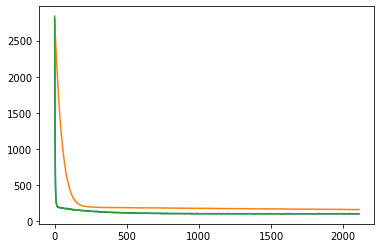

In [78]:
fig, ax = plt.subplots()
# fig.set_dpi(100)

ax.plot(valid_loss)
ax.plot(valid_loss3)
ax.plot(valid_loss2)
# ax.plot([1,3],[1,100])

In [36]:
a == 0

Executing op Equal in device /job:localhost/replica:0/task:0/device:GPU:0


<tf.Tensor: shape=(1, 2), dtype=bool, numpy=array([[False, False]])>

In [37]:
a = np.array([1, 0, 0, 1])
a1 = np.array([1,0])
b = np.array([[1, 2, 3, 4], [11,23,33,44]])

b[(a1 == 0) == False, a == 0]

array([2, 3])

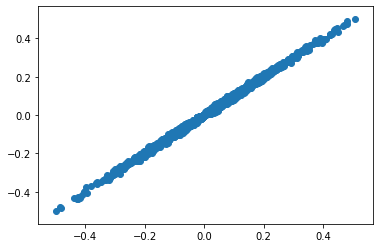

In [79]:
plt.scatter(model.A[:, 0], model2.A[:, 0])

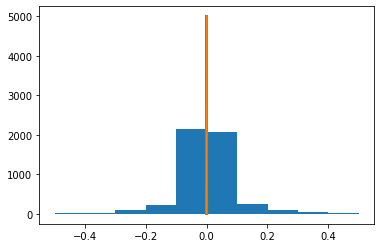

In [80]:
a1 = np.array(model.A[:, 0])
a2 = np.array(model2.A[:, 0])
plt.hist(a2)
for i in a2[a1==0]:
    plt.plot([i, 0], [i, 5000])

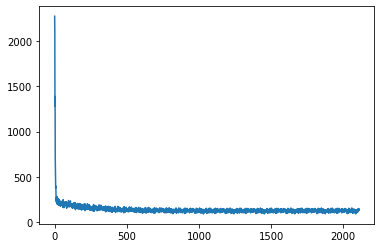

In [81]:
plt.plot(train_loss)

In [82]:
model_true.loss(xxtest, yytest)

<tf.Tensor: shape=(), dtype=float32, numpy=99.57907>

In [83]:
model.loss(xxtest, yytest)

<tf.Tensor: shape=(), dtype=float32, numpy=106.45781>

In [84]:
model2.loss(xxtest, yytest)

<tf.Tensor: shape=(), dtype=float32, numpy=106.6431>

In [85]:
model3.loss(xxtest, yytest)

<tf.Tensor: shape=(), dtype=float32, numpy=164.5487>

In [86]:
model2.objective(x, y)

(<tf.Tensor: shape=(), dtype=float32, numpy=224.08914>,
 <tf.Tensor: shape=(), dtype=float32, numpy=97.98162>)

In [87]:
model.objective(x, y)

(<tf.Tensor: shape=(), dtype=float32, numpy=224.46591>,
 <tf.Tensor: shape=(), dtype=float32, numpy=98.81148>)

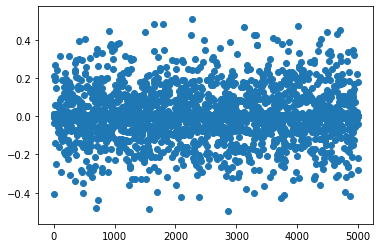

In [88]:
plt.scatter(range(model.A.shape[0]), model.A[:,0])

## Implementing the regularization path

One thing to notice is to compute upper bound on $\lambda$: $|\nabla g(A = 0, b = \bar{y})| \le \lambda \Rightarrow \lambda_\max = \max_i |\nabla g(A = 0, b = \bar{y})_i|$



In [89]:
def get_lambda_max(model, x, y):
    a = model.A
    b = model.b
    model.A.assign(tf.zeros(a.shape))
    model.b.assign(tf.ones(b.shape), tf.reduce_mean(y))
    with tf.GradientTape() as tape:
        obj, loss = model.proximal_obj(x, y)
    grad = tape.gradient(obj, [model.proximal_variables, model.not_prox_variables])
    l1_max = tf.reduce_max(tf.abs(grad[0]))
    lambda_max = l1_max / model.alpha
    return lambda_max
def get_lambda_sequence(lambda_max, lambda_min, nlambda):
    seq = np.linspace(np.log(lambda_max), np.log(lambda_min), num = nlambda)
    return np.exp(seq)

In [155]:
Xsmall = tfio.IODataset.from_hdf5('/vol/bmd/yanyul/test_data/tf_elastic_net/example_X.hdf5', '/Xtrain')
ysmall = tfio.IODataset.from_hdf5('/vol/bmd/yanyul/test_data/tf_elastic_net/example_X.hdf5', '/ytrain')
dataset_small = tf.data.Dataset.zip((Xsmall.take(5000), ysmall.take(5000)))
dataset_small = dataset_small.map(lambda x , y : (tf.cast(x, tf.float32), tf.cast(y, tf.float32)))
dataset_small = dataset_small.batch(500).repeat(100)

Executing op IO>HDF5ReadableInit in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op SkipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorSliceDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ConcatenateDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op UnbatchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op IO>HDF5ReadableInit in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op SkipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executin

In [156]:
model_lseq = ElasticNet(X.element_spec.shape[0], alpha, llambda)
lambda_max = get_lambda_max(model_lseq, xxtest, yytest)
lambda_seq = get_lambda_sequence(lambda_max, lambda_max / 1e5, 10)
valid_loss = []
n = 0
for lambda_i in lambda_seq:
    print('lambda = {}'.format(lambda_i))
    model_lseq.update_lambda(lambda_i)
    i = 0
    for x, y in dataset_small:
        if i % 100 == 0:
            print('i = {}, model1 = {}'.format(i, model_lseq.loss(x, y)))
        i += 1
        n += 1
    #     obj, loss = train_step(model, x, y, optimizer)
        obj, loss = proximal_train_step(model_lseq, x, y)
        vloss = model_lseq.loss(xxtest, yytest)
        valid_loss.append([lambda_i, i, vloss, n])
#         obj2, loss2 = train_step(model2, x, y, optimizer)
#         obj3, loss3 = train_step(model3, x, y, optimizer3)
        
#         print('i = {}, model2 = {}'.format(i, model2.loss(x, y)))
#         print('i = {}, model3 = {}'.format(i, model3.loss(x, y)))
#         train_loss.append(loss)
#         train_obj.append(obj)
#         valid_loss.append(model.loss(xxtest, yytest))
#         valid_loss2.append(model2.loss(xxtest, yytest))
#         valid_loss3.append(model3.loss(xxtest, yytest))

lambda = 89.37634284100845
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
i = 0, model1 = 2730.748779296875
lambda = 8.937634471848991
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
i = 0, model1 = 2690.677978515625
lambda = 0.893763465959714
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
i = 0, model1 = 285.5649108886719
lambda = 0.0893763484734529
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
i = 0, model1 = 98.12367248535156
lambda = 0.008937635035093452
Executing op OptimizeDataset in device /job:localhost/replica:0/t

In [157]:
valid_loss = np.array(valid_loss)

In [158]:
model_lseq.loss(xxtest, yytest)

<tf.Tensor: shape=(), dtype=float32, numpy=110.592674>

In [167]:
model_lseq.objective(xxtest, yytest)

(<tf.Tensor: shape=(), dtype=float32, numpy=110.59269>,
 <tf.Tensor: shape=(), dtype=float32, numpy=110.592674>)

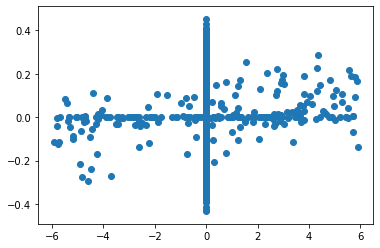

In [165]:
plt.scatter(model_true.A[:,0], model_lseq.A[:,0])

In [166]:
valid_loss.shape

(1000, 4)

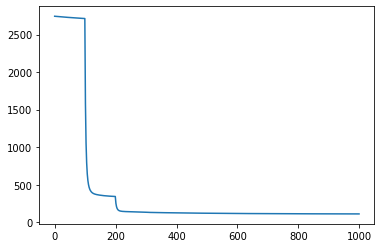

In [160]:
plt.plot(valid_loss[:,2])

Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
